In [1]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sbn
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
player_ratings = pd.read_csv('.\data\player_ratings.csv')
player_ratings.describe()

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
count,8.342260e+05,8.342260e+05,8.342260e+05,834226.000000,834226.000000
mean,-9.225868e+07,5.479852e+00,1.095979e+01,25.112577,7.270275
std,8.103222e+07,1.760984e+03,3.629559e+03,3.231603,1.128826
min,-2.991940e+08,0.000000e+00,1.000000e+00,4.993478,1.404098
25%,-1.499249e+08,0.000000e+00,1.000000e+00,22.906655,6.957458
50%,-9.585022e+07,1.000000e+00,2.000000e+00,25.018193,7.732504
75%,4.883475e+04,3.000000e+00,6.000000e+00,27.240350,8.058739
max,3.305130e+05,1.608398e+06,3.315071e+06,48.825892,8.333689


Player rating is based on trueskill_mu, which is the skill, where the higher the rating value the better. The trueskill_sigma is the uncertainty of the rating. Calculated the ratings on 900k mathces which occured prior to other uploaded datasets on kaggle.

In [3]:
player_ratings['trueskill_mu'].describe()

count    834226.000000
mean         25.112577
std           3.231603
min           4.993478
25%          22.906655
50%          25.018193
75%          27.240350
max          48.825892
Name: trueskill_mu, dtype: float64

The players skill level in this data set ranges from 4.99 to 48.8, with the mean skill level of 25

In [4]:
bins = [0, 22.9,27.24,50]
labels = [0,1,2]
player_ratings['skill_labels'] = pd.cut(player_ratings['trueskill_mu'], bins = bins, include_lowest=False, right = True,labels = labels) 

wins_skill = player_ratings.drop(['account_id','trueskill_sigma'],axis=1)
wins_skill['win_rate'] = (wins_skill['total_wins'] / wins_skill['total_matches'])
wins_skill.head()

,total_wins,total_matches,trueskill_mu,skill_labels,win_rate
0,14,24,27.868035,2,0.583333
1,1,1,26.544163,1,1.000000
2,1,1,26.521103,1,1.000000
3,1,1,27.248025,2,1.000000
4,0,1,22.931016,1,0.000000


C:\Users\ruzzo\AppData\Local\Temp/ipykernel_15504/3296480586.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  beginner.hist(ax=ax)


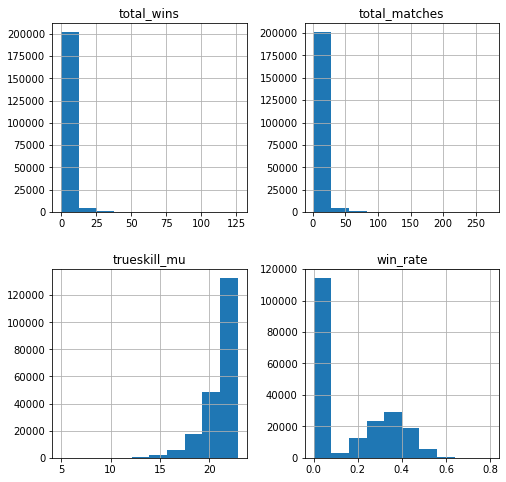

In [5]:
#Histograms by skill level
#Level = 0
beginner = wins_skill[wins_skill['skill_labels'] == 0]
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
beginner.hist(ax=ax)
plt.show()

C:\Users\ruzzo\AppData\Local\Temp/ipykernel_15504/2535203137.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  intermediate.hist(ax=ax)


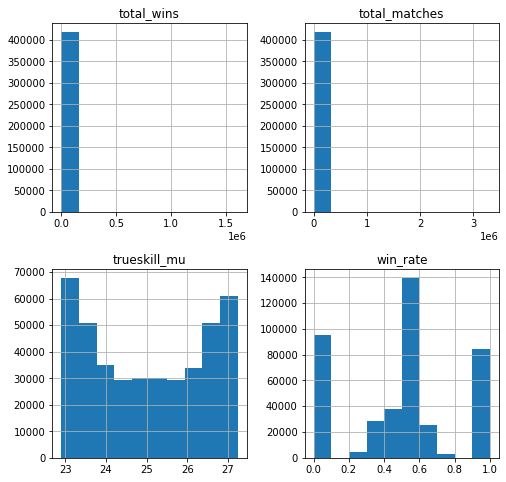

In [6]:
#Histograms by skill level
#Level = 1
intermediate = wins_skill[wins_skill['skill_labels'] == 1]
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
intermediate.hist(ax=ax)
plt.show()

C:\Users\ruzzo\AppData\Local\Temp/ipykernel_15504/4105828768.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pro.hist(ax=ax)


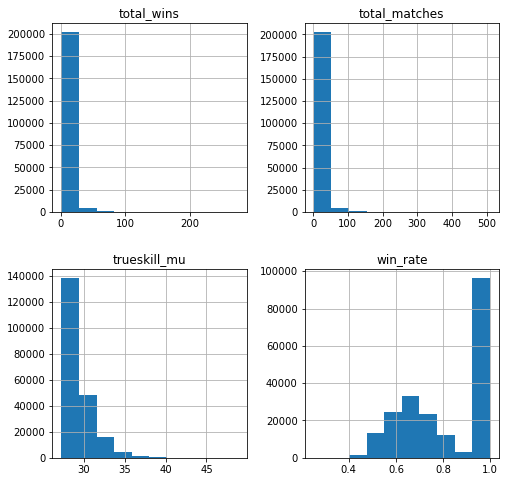

In [7]:
#Histograms by skill level
#Level = 2
pro = wins_skill[wins_skill['skill_labels'] == 2]
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
pro.hist(ax=ax)
plt.show()

<AxesSubplot:>

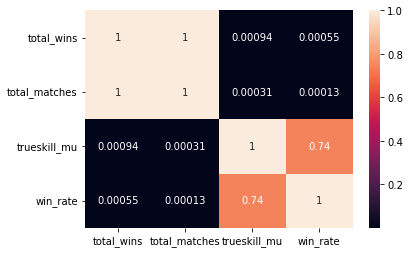

In [8]:
#Correlation heatmap
sbn.heatmap(wins_skill.corr(),annot=True)

Text(0.5, 1.0, 'Wins vs Skill Level')

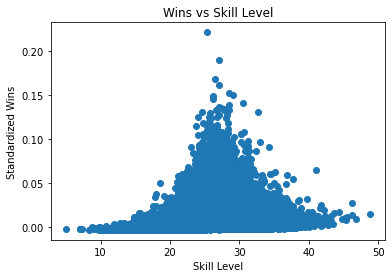

In [9]:
#Standardizing the wins and matches data then plotting them
scaler = StandardScaler()
data = scaler.fit(wins_skill[['total_wins', 'total_matches']])
data = scaler.transform(wins_skill[['total_wins', 'total_matches']])
data = pd.DataFrame(data=data, columns = (['total_wins','total_matches']))
data = data.assign(trueskill_mu = wins_skill['trueskill_mu'], skill_labels = wins_skill['skill_labels'], win_rate = wins_skill['win_rate'])
#Removing outlier that threw off the scale of the graph
data.drop(data[data['total_wins'] > 800].index, inplace=True)

plt.scatter(x = data['trueskill_mu'], y = data['total_wins'])
plt.ylabel("Standardized Wins")
plt.xlabel("Skill Level")
plt.title("Wins vs Skill Level")

Text(0.5, 1.0, 'Total Matches vs Skill Level')

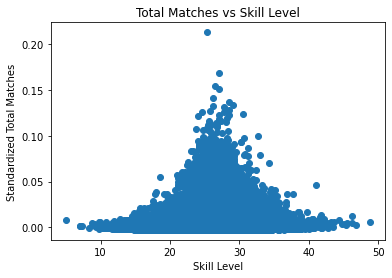

In [10]:
#Total matches versus skill level
plt.scatter(x = data['trueskill_mu'], y = data['total_matches'])
plt.ylabel("Standardized Total Matches")
plt.xlabel("Skill Level")
plt.title("Total Matches vs Skill Level")

Text(0.5, 1.0, 'Wins vs Matches')

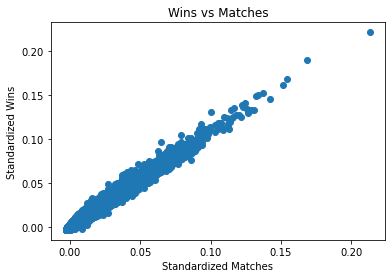

In [11]:
#Wins vs Matches
plt.scatter(x = data['total_matches'], y = data['total_wins'])
plt.ylabel("Standardized Wins")
plt.xlabel("Standardized Matches")
plt.title("Wins vs Matches")

Text(0.5, 1.0, 'Win Rate vs Skill Level')

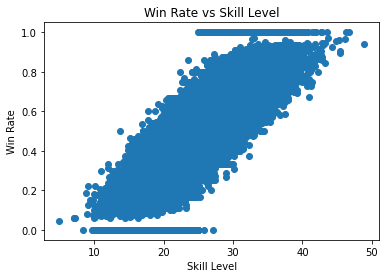

In [21]:
#Win rate versus skill level
plt.scatter(x = data['trueskill_mu'], y = data['win_rate'])
plt.ylabel("Win Rate")
plt.xlabel("Skill Level")
plt.title("Win Rate vs Skill Level")

As we can see the win rate is positively linearly correlated with the skill level. By using the total wins and total matches played, we might be able to predict/classify the skill level of a player

In [13]:
#Training a kNN model with training and testing data
X = data[['total_wins', 'total_matches']]
y = data['skill_labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
score = knn.score(X_test, y_test)
print(score)

0.6980610746501243


C:\Users\ruzzo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


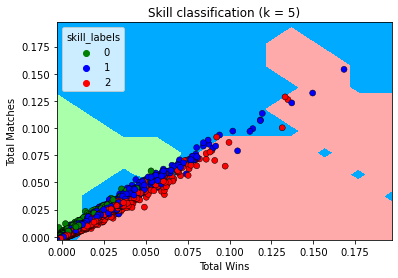

In [15]:
from matplotlib.colors import ListedColormap
# Create color maps
cmap_light = ListedColormap(['#AAFFAA','#00AAFF','#FFAAAA'])
cmap_bold = ['g','b','r']

# calculate min, max and limits
x_min, x_max = X.iloc[:, 0].min(), X.iloc[:, 0].max() -0.01
y_min, y_max = X.iloc[:, 1].min(), X.iloc[:, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
np.arange(y_min, y_max, 0.02))

# predict class using data and kNN classifier
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=cmap_light)

scatter = sbn.scatterplot(X_test.iloc[:, 0], X_test.iloc[:, 1], hue = y_test, palette=cmap_bold, alpha = 1.0, edgecolor='black')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Skill classification (k = 5)")
plt.xlabel('Total Wins')
plt.ylabel('Total Matches')
plt.show()

The green labels/area represents begginer skill level (bottom quartile), blue represents intermediate, and red represents pro. It appears that beginners dont play that many matches or win many games. Whereas the pro skill level tend to win a higher percentage of games compared ot the other two levels.

In [23]:
#Linear regression comparing win rate with skill
win_data = pd.DataFrame(np.asarray(data['win_rate']), columns = ['Win Rate'])
win_data['Skill'] = np.asarray(data['trueskill_mu'])

X = win_data.iloc[:,:-1]
y = win_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


Training scores: [0.54814501 0.5516145  0.54694377 0.54881804 0.54745477 0.55000451
 0.5500855  0.54946165 0.54869533 0.54726539]
Mean Score: 0.5488488479688403
Mean squared error: 4.721677945877811
Coefficient of determination (R2): 0.5477733724182972


Text(0.5, 1.0, 'Win Rate and Skill Level Regression')

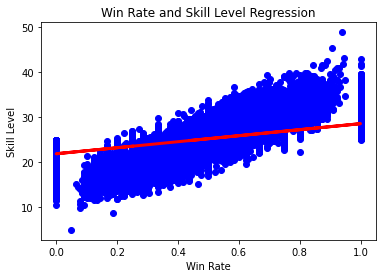

In [26]:
#Linear Regression model 10 fold CV
lg = LinearRegression()
scores = cross_val_score(lg, X_train, y_train, cv= 10)
print("Training scores: " + str(scores))
print("Mean Score: " + str(np.mean(scores)))

lg = lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))

#Scatter plot of linear regression on all the data features

plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red", linewidth = 3)
plt.ylabel("Skill Level")
plt.xlabel("Win Rate")
plt.title("Win Rate and Skill Level Regression")

In [29]:
#Removing all win rates of 0.0 and 1.0
win_data.drop(win_data[ (win_data['Win Rate'] == 0 )].index, inplace = True)
win_data.drop(win_data[ (win_data['Win Rate'] == 1)].index, inplace = True)
win_data.describe()

,Win Rate,Skill
count,443758.000000,443758.000000
mean,0.502677,25.314724
std,0.149601,3.315009
min,0.047619,4.993478
25%,0.400000,23.324910
50%,0.500000,25.225921
75%,0.600000,27.266155
max,0.970588,48.825892


In [30]:
#Training linear regression model with new data set (removed 0.0 and 1.0 win rates)
X = win_data.iloc[:,:-1]
y = win_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Training scores: [0.67516954 0.68110819 0.67864703 0.6757222  0.67849645 0.67836624
 0.67999649 0.67731565 0.68021698 0.67983881]
Mean Scores: 0.6784877574188218
Mean squared error: 3.520001125570377
Coefficient of determination (R2): 0.6785182499489575


Text(0.5, 1.0, 'Win Rate (Removed 0.0, 1.0) and Skill Level Regression')

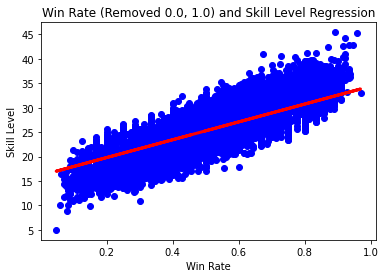

In [32]:
#Linear Regression model 10 fold CV with removed 0.0 and 1.0 win rates
lg = LinearRegression()
scores = cross_val_score(lg, X_train, y_train, cv= 10)
print("Training scores: " + str(scores))
print("Mean Scores: " + str(np.mean(scores)))

lg = lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))

#Scatter plot of linear regression on all the data features

plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red", linewidth = 3)
plt.ylabel("Skill Level")
plt.xlabel("Win Rate")
plt.title("Win Rate (Removed 0.0, 1.0) and Skill Level Regression")